In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd

import importlib

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import policies
import bbDebiasing as bbDebias
import maxEnsembleDebias as maxDebias

import matplotlib.pyplot as plt

import time

Reading in data. It's stored in two separate files for two separate electricity transformers at two different stations, so have to merge them together based on timestamp. Then, since we're not treating this directly as time series data, have to convert time stamps into something that is digestible by a regular regression model.

In [5]:
# reading in the data
data1 = pd.read_csv('../data/ETDataset/ETT-small/ETTm1.csv')
data2 = pd.read_csv('../data/ETDataset/ETT-small/ETTm2.csv')

# converting dates to timestamps for the merge operation
data1['date'] = pd.to_datetime(data1['date'])
data2['date'] = pd.to_datetime(data2['date'])

# merging together vis-a-vis timestamps
data = pd.merge(data1, data2, on='date', how='outer', suffixes=['1','2'])

# check for nans
data.isna().sum()

# convert dates to something understandable to regression
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

# remove the date column
data.drop(columns='date')

,HUFL1,HULL1,MUFL1,MULL1,LUFL1,LULL1,OT1,HUFL2,HULL2,MUFL2,MULL2,LUFL2,LULL2,OT2,month,day,hour,minute
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999,7,1,0,0
1,5.760,2.076,1.492,0.426,4.264,1.401,30.459999,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000,7,1,0,15
2,5.760,1.942,1.492,0.391,4.234,1.310,30.038000,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002,7,1,0,30
3,5.760,1.942,1.492,0.426,4.234,1.310,27.013000,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001,7,1,0,45
4,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001,7,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69675,9.310,3.550,5.437,1.670,3.868,1.462,9.567000,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500,6,26,18,45
69676,10.114,3.550,6.183,1.564,3.716,1.462,9.567000,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500,6,26,19,0
69677,10.784,3.349,7.000,1.635,3.746,1.432,9.426000,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501,6,26,19,15
69678,11.655,3.617,7.533,1.706,4.173,1.523,9.426000,40.459999,11.392,51.841999,11.929,-11.536,-1.418,45.546501,6,26,19,30


Splitting into train and test sets and extracting out the features. The target is "oil temperature", which apparently has something to do with load, and if temperature is too high, load has to be diverted elsewhere because the transformer will explode otherwise. ¯\\_(ツ)_/¯

Current debiasing code is written assuming data is stored as numpy arrays not as pandas, so also have to convert in this step.

In [6]:
features = ['HUFL1', 'HULL1', 'MUFL1', 'MULL1', 'LUFL1', 'LULL1', 'HUFL2', 'HULL2', 'MUFL2', 'MULL2', 'LUFL2', 'LULL2','month','day','hour','minute']
targets = ['OT1', 'OT2']

X = data[features].values
Y = data[targets].values 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Training two gradient boosting regressors, one on each of the targets.

In [8]:
gb1 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb1.fit(X_train, Y_train[:,0])


gb2 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb2.fit(X_train, Y_train[:,1])


GradientBoostingRegressor(max_depth=6, random_state=42)

Verifying that the error is at least sort of on correct scale for the data.

In [9]:
print(f"Min OT Value: {Y_train.min()}")
print(f"Max OT Value: {Y_train.max()}")
preds1 = gb1.predict(X_test)
preds2 = gb2.predict(X_test)
print(f"MSE of predictor on 1st station {mse(Y_test[:,0], preds1)}")
print(f"MSE of predictor on 2nd station {mse(Y_test[:,1], preds2)}")

Min OT Value: -4.2210001945495605
Max OT Value: 58.87699890136719
MSE of predictor on 1st station 3.731832659817428
MSE of predictor on 2nd station 6.7934090398713565


Building two composite predictors, which each use gradient boosting for one coordinate of prediction vector and predict label mean for other coordinate.  

In [10]:
def h1(xs):
    col1 = gb1.predict(xs)
    col2 = np.full(len(xs), Y_train[:,0].mean())
    return np.column_stack((col1, col2))


def h2(xs):
    col1 = np.full(len(xs), Y_train[:,1].mean())
    col2 = gb2.predict(xs)
    return np.column_stack((col1, col2))

Building policies. For now, just the basic simplex policies.

In [11]:
# policy1 = policies.ElectricTransformer(2, h1, 0.1, 25)
# policy2 = policies.ElectricTransformer(2, h2, 0.1, 25)

policy1 = policies.Simplex(2, h1)
policy2 = policies.Simplex(2, h2)

# Bias Bounties Method

In [12]:
def init_model(xs):
    col1 = np.full(len(xs), Y_train[:,0].mean())
    col2 = np.full(len(xs), Y_train[:,1].mean())
    return np.column_stack((col1, col2))

init_policy = policies.Simplex(2, init_model)

max_depth = 100
tolerance = 0.01
bbModel = bbDebias.bbDebias(init_model, init_policy, X_train, Y_train, max_depth, tolerance)
bbModel.debias([h1,h2], [policy1, policy2])

Hit tolerance; halting debiasing.


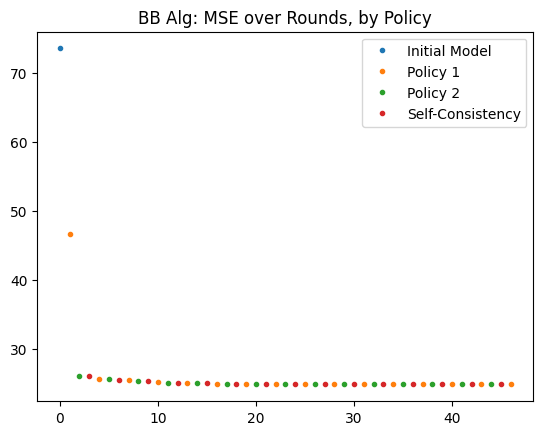

In [13]:
mses = np.array([mse(Y_train, pred, multioutput='raw_values') for pred in bbModel.predictions_by_round])

coord = 0
plt.plot(0,mses[0][coord],'.', label="Initial Model")
for i in range(1, bbModel.n_models+1):
    indices = list(range(len(bbModel.predictions_by_round)))[i::(bbModel.n_models + 1)]
    plt.plot(indices, mses[i::(bbModel.n_models + 1)][:, coord], '.', label=f"Policy {i}")
indices = list(range(len(bbModel.predictions_by_round)))[(bbModel.n_models+1)::(bbModel.n_models + 1)]
plt.plot(indices, mses[(bbModel.n_models+1)::(bbModel.n_models + 1)][:, coord], '.', label="Self-Consistency")
plt.legend()
plt.title("BB Alg: MSE over Rounds, by Policy");

Comparison of MSE of our final model vs the MSEs of the original models in the first coordinate:

In [14]:
print(f"(Training) MSE of our model in 1st coordinate: {mses[-1][0]}")
print(f"(Training) MSE of model 1 in 1st coordinate:  {mse(Y_train, h1(X_train), multioutput='raw_values')[0]}")
print(f"(Training) MSE of model 2 in 1st coordinate: {mse(Y_train, h2(X_train), multioutput='raw_values')[0]}")

(Training) MSE of our model in 1st coordinate: 24.91174292776016
(Training) MSE of model 1 in 1st coordinate:  3.2606036443667277
(Training) MSE of model 2 in 1st coordinate: 249.96925444518638


I.e., at least with the naive simplex policy, we don't match performance of the better of the two initial predictors in terms of squared error. 

Comparison of MSE overall:

In [15]:
print(f"(Training) MSE of our model: {mses[-1].mean()}")
print(f"(Training) MSE of model 1:  {mse(Y_train, h1(X_train))}")
print(f"(Training) MSE of model 2: {mse(Y_train, h2(X_train))}")

(Training) MSE of our model: 32.2312074615876
(Training) MSE of model 1:  160.48362803566994
(Training) MSE of model 2: 127.987308858443


So, we do better overall than the original models. 

Text(0.5, 1.0, 'BB Alg: Predicted and Realized Revenue over Rounds')

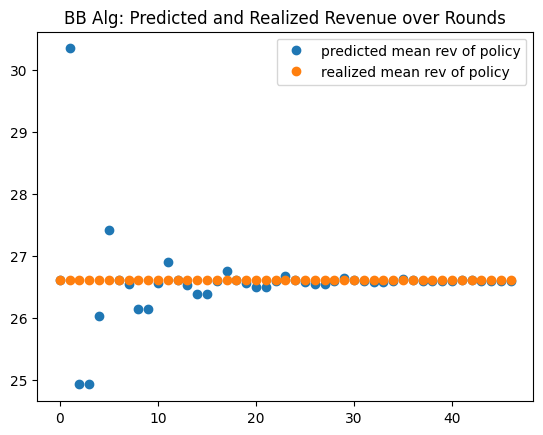

In [16]:
# predicted revenue of each point per round
pred_rev = [np.einsum('ij,ij->i', bbModel.predictions_by_round[i], init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized revenue
true_rev = [np.einsum('ij,ij->i', Y_train, init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))]


plt.plot(range(len(bbModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean rev of policy")
plt.plot(range(len(bbModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean rev of policy")
plt.legend()
plt.title("BB Alg: Predicted and Realized Revenue over Rounds")

# Max Ensemble Method

In [17]:
max_depth =100
tolerance = 0.1
maxModel = maxDebias.EnsembledModel([h1,h2], [policy1, policy2], X_train, Y_train, max_depth, tolerance)
maxModel.debias()

Hit tolerance; halting debiasing.


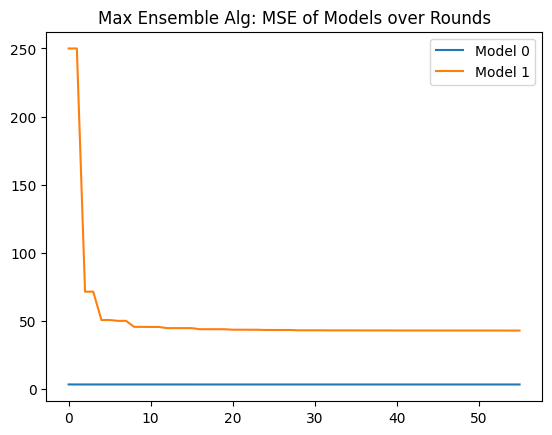

In [18]:
preds = np.array(maxModel.predictions_by_round)

preds_by_model = [preds[:,i] for i in range(maxModel.n_models)]
mses_by_model = np.zeros((len(preds_by_model), len(preds), maxModel.pred_dim))
for i in range(maxModel.n_models):
    for j in range(len(preds_by_model[i])):
        mses_by_model[i][j] = mse(Y_train, preds_by_model[i][j], multioutput='raw_values')

coord = 0
for i in range(maxModel.n_models):
    plt.plot(np.arange(len(maxModel.predictions_by_round)), mses_by_model[i][:,coord], label=f"Model {i}")
plt.legend()
plt.title("Max Ensemble Alg: MSE of Models over Rounds");

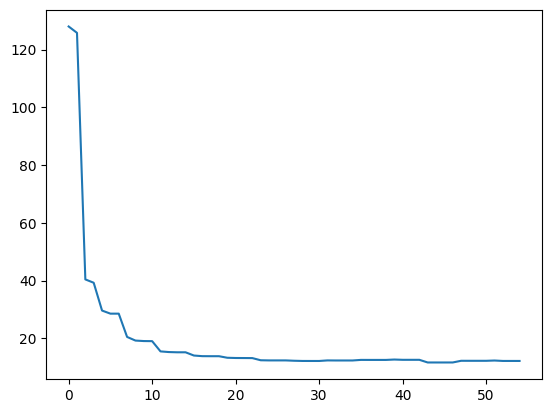

In [19]:
ensemble_mse = np.array([mse(Y_train, maxModel.meta_model_pred_by_round[i]) for i in range(len(maxModel.meta_model_pred_by_round))])
coord = 0

plt.plot(np.arange(len(ensemble_mse)), ensemble_mse)

Comparing final MSEs of meta algorithm, BB method, and original models

In [20]:
print(f"(Training) MSE of BB Model in 1st coordinate: {mse(Y_train, bbModel.predictions_by_round[-1], multioutput='raw_values')[0]}")
print(f"(Training) MSE of Max Ensemble Model in 1st coordinate: {mse(Y_train, maxModel.meta_model_pred_by_round[-1], multioutput='raw_values')[0]}")
print(f"(Training) MSE of Model 1 in 1st coordinate:  {mse(Y_train, h1(X_train), multioutput='raw_values')[0]}")
print(f"(Training) MSE of Model 2 in 1st coordinate: {mse(Y_train, h2(X_train), multioutput='raw_values')[0]}")

(Training) MSE of BB Model in 1st coordinate: 24.91174292776016
(Training) MSE of Max Ensemble Model in 1st coordinate: 18.32419837373195
(Training) MSE of Model 1 in 1st coordinate:  3.2606036443667277
(Training) MSE of Model 2 in 1st coordinate: 249.96925444518638


And overall MSE

In [21]:
print(f"(Training) MSE of BB Model: {mse(Y_train, bbModel.predictions_by_round[-1])}")
print(f"(Training) MSE of Max Ensemble Model: {ensemble_mse[-1]}")
print(f"(Training) MSE of Model 1:  {mse(Y_train, h1(X_train))}")
print(f"(Training) MSE of Model 2: {mse(Y_train, h2(X_train))}")

(Training) MSE of BB Model: 32.2312074615876
(Training) MSE of Max Ensemble Model: 12.192979078036055
(Training) MSE of Model 1:  160.48362803566994
(Training) MSE of Model 2: 127.987308858443


# Comparing Methods on Revenue Objective

This needs added.

# Testing Policy

Note: Something wrong with this policy. Initial sanity checks passed, but when run on whole dataset, model never updates. Need to investigate more, but currently runs too slowly (e.g. overnight).


Running on very small subset of data

In [ ]:
# importlib.reload(policies)
# policy = policies.ElectricTransformer(2, h1, 0.1, 25)
# alloc = policy.run_given_preds(Y_train[0:5])

i 0


/opt/anaconda3/envs/bb-portfolio/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Checking that constraints met

In [ ]:
# print("Allocation: \n", alloc)
# print("Predictions: \n", Y_train[0:5])
# print("Dot product: ", np.einsum('ij,ij->i', Y_train[0:5], alloc))
# print("Sum of weights accross allocations: ", alloc.sum(axis=1))
# print("Violations of min allocation? ", np.sum(alloc<0))
# print("Violations of max allocation? ", np.sum(alloc>1))

Allocation: 
 [[3.87780077e-01 6.12219923e-01]
 [6.77439029e-12 1.00000000e+00]
 [4.22319282e-01 5.77680718e-01]
 [1.56929188e-01 8.43070812e-01]
 [4.30984071e-01 5.69015929e-01]]
Predictions: 
 [[16.25       40.83499908]
 [ 2.74399996 11.19649982]
 [17.09399986 43.2765007 ]
 [12.10000038 29.6534996 ]
 [21.87800026 43.9355011 ]]
Dot product:  [31.30142624 11.19649982 32.21912574 26.89884323 34.4290696 ]
Sum of weights accross allocations:  [1. 1. 1. 1. 1.]
Violations of min allocation?  0
Violations of max allocation?  0


Timing how long optimization runs on whole dataset

In [ ]:

# start_time = time.time()
# alloc = policy.run_given_preds(Y_test)

# # Record the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

i 0


/opt/anaconda3/envs/bb-portfolio/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


i 1000
i 2000
i 3000
i 4000
i 5000
i 6000
i 7000
i 8000
i 9000
i 10000
i 11000
i 12000
i 13000


In [ ]:
elapsed_time

71.14155411720276